---
## Section 1: Understanding RAG Components (~30 min)
---

### 1.1 Why RAG?

Large Language Models are powerful, but they have critical limitations:

| Limitation | Description | RAG Solution |
|-----------|-------------|-------------|
| **Knowledge Cutoff** | LLMs only know what they were trained on | Retrieve up-to-date documents |
| **Hallucinations** | LLMs confidently generate false information | Ground answers in retrieved context |
| **No Domain Knowledge** | General models lack specialized expertise | Index domain-specific documents |

**RAG vs Fine-tuning:**

| Aspect | RAG | Fine-tuning |
|--------|-----|-------------|
| Data freshness | Real-time (just update the index) | Requires retraining |
| Cost | Low (no training compute) | High (GPU hours) |
| Transparency | Can cite sources | Black box |
| Best for | Factual Q&A, documentation | Style/behavior changes |

**RAG Architecture:**

```
Query → [Retrieval from Vector Store] → Context + Prompt → [LLM] → Grounded Answer
```

Let's build each component step by step.

### 1.2 Data Loading

We'll use **Covestro Safety Data Sheets (SDS)** as our knowledge base. These are standardized 16-section GHS documents covering hazard identification, handling procedures, PPE requirements, and more for industrial chemical products.

Our approach:
1. Use `PyMuPDF` (fitz) to extract text from each PDF
2. Parse metadata (product name, material number, chemical family, use)
3. Split each SDS into its 16 standard sections
4. Store each section as a LangChain `Document` with rich metadata

In [ ]:
import fitz  # PyMuPDF
from pathlib import Path
from langchain_core.documents import Document

# Demo: extract text from a single SDS PDF
pdf_path = Path("data/80103425 EN US.pdf")
doc = fitz.open(str(pdf_path))

print(f"PDF: {pdf_path.name}")
print(f"Pages: {len(doc)}")

full_text = ""
for page in doc:
    full_text += page.get_text()
doc.close()

print(f"Total characters: {len(full_text):,}")
print(f"\nFirst 500 chars:\n{full_text[:500]}...")

PDF: 80103425 EN US.pdf
Pages: 7
Total characters: 13,217

First 500 chars:
 
Material Name: BAYBLEND M750 000000 
Material Number: 80103425 
 Page: 1 of 7 
 
 
SAFETY DATA SHEET 
 
 
1. Identification  
 
 
 
 
 
 
 
 
 
 
Product Name: 
BAYBLEND M750 000000 
Material Number: 
80103425 
Chemical Family: 
Thermoplastic Polymer 
Use: 
Production of molded plastic articles 
 
2. Hazards Identification  
 
GHS Classification 
This product is not hazardous in the form in which it is shipped by the manufacturer. 
 
GHS Label Elements 
Signal word: 
 
Warning 
 
Hazard statem...


In [ ]:
import re

SDS_SECTIONS = {
    1: "Identification", 2: "Hazards Identification",
    3: "Composition/Information on Ingredients", 4: "First Aid Measures",
    5: "Firefighting Measures", 6: "Accidental Release Measures",
    7: "Handling and Storage", 8: "Exposure Controls/Personal Protection",
    9: "Physical and Chemical Properties", 10: "Stability and Reactivity",
    11: "Toxicological Information", 12: "Ecological Information",
    13: "Disposal Considerations", 14: "Transportation Information",
    15: "Regulatory Information", 16: "Other Information",
}

def _extract_metadata(text):
    metadata = {"product_name": "", "material_number": "", "chemical_family": "", "use": ""}
    m = re.search(r"Product Name:\s*\n?\s*(.+?)(?:\n|Material Number)", text)
    if m: metadata["product_name"] = m.group(1).strip()
    m = re.search(r"Material Number:\s*\n?\s*(\d+)", text)
    if m: metadata["material_number"] = m.group(1).strip()
    m = re.search(r"Chemical Family:\s*\n?\s*(.+?)(?:\n|Use:)", text)
    if m: metadata["chemical_family"] = m.group(1).strip()
    m = re.search(r"Use:\s*\n?\s*(.+?)(?:\n\s*\n|\n\d+\.)", text, re.DOTALL)
    if m: metadata["use"] = re.sub(r"\s+", " ", m.group(1).strip())
    return metadata

def _split_into_sections(text):
    pattern = r"(?=\n\s*(\d{1,2})\.\s+([A-Z][^\n]+))"
    matches = list(re.finditer(pattern, text))
    sections = {}
    for i, match in enumerate(matches):
        sec_num = int(match.group(1))
        if sec_num < 1 or sec_num > 16: continue
        start = match.start()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        sections[sec_num] = text[start:end].strip()
    return sections

def load_pdf(pdf_path):
    pdf_path = Path(pdf_path)
    doc = fitz.open(str(pdf_path))
    text = "".join(page.get_text() for page in doc)
    doc.close()
    metadata = _extract_metadata(text)
    sections = _split_into_sections(text)
    documents = []
    for sec_num, sec_text in sorted(sections.items()):
        sec_title = SDS_SECTIONS.get(sec_num, f"Section {sec_num}")
        documents.append(Document(
            page_content=sec_text,
            metadata={**metadata, "section_number": sec_num, "section_title": sec_title, "source": pdf_path.name},
        ))
    return documents

def get_documents(data_dir=None):
    data_path = Path(data_dir) if data_dir else Path("data")
    documents = []
    for pdf_path in sorted(data_path.glob("*.pdf")):
        docs = load_pdf(pdf_path)
        documents.extend(docs)
        product = docs[0].metadata["product_name"] if docs else pdf_path.name
        print(f"  Loaded {pdf_path.name}: {product} ({len(docs)} sections)")
    print(f"\nTotal documents loaded: {len(documents)}")
    return documents

# Load all SDS documents
documents = get_documents()

# Print stats
print(f"\n--- Document Stats ---")
print(f"Total documents: {len(documents)}")
print(f"Total characters: {sum(len(d.page_content) for d in documents):,}")
products = sorted(set(d.metadata['product_name'] for d in documents))
print(f"Products covered: {products}")
print(f"\nSample metadata: {documents[0].metadata}")
print(f"Sample content: {documents[0].page_content[:150]}...")

  Loaded 80103425 EN US.pdf: BAYBLEND M750 000000 (16 sections)
  Loaded 80129793 EN US.pdf: BAYBOND PU 407 (16 sections)
  Loaded 80171331 EN US.pdf: BAYBOND XL 7270 (16 sections)
  Loaded 80171366 EN US.pdf: DISPERCOLL U 8755 (16 sections)
  Loaded 80212926 EN US.pdf: DESMOPHEN XP 2680 (16 sections)
  Loaded 80343256 EN US.pdf: BAYBLEND M303 FR 000000 (16 sections)

Total documents loaded: 96

--- Document Stats ---
Total documents: 96
Total characters: 96,204
Products covered: ['BAYBLEND M303 FR 000000', 'BAYBLEND M750 000000', 'BAYBOND PU 407', 'BAYBOND XL 7270', 'DESMOPHEN XP 2680', 'DISPERCOLL U 8755']

Sample metadata: {'product_name': 'BAYBLEND M750 000000', 'material_number': '80103425', 'chemical_family': 'Thermoplastic Polymer', 'use': 'Production of molded plastic articles', 'section_number': 1, 'section_title': 'Identification', 'source': '80103425 EN US.pdf'}
Sample content: 1. Identification  
 
 
 
 
 
 
 
 
 
 
Product Name: 
BAYBLEND M750 000000 
Material Number: 
801

### 1.3 Chunking Strategies

Documents are often too long to fit in an LLM's context window or to be useful for precise retrieval. **Chunking** breaks them into smaller, manageable pieces.

**Why chunk?**
- LLMs have limited context windows
- Smaller chunks = more precise retrieval
- Reduces cost (fewer tokens per query)

**Types of chunking:**

| Strategy | How it works | Pros | Cons |
|----------|-------------|------|------|
| **Fixed-size** | Split every N characters | Simple, predictable | Breaks mid-sentence |
| **Recursive** | Split on `\n\n`, then `\n`, then `. `, then ` ` | Respects structure | Slightly complex |
| **Semantic** | Split by meaning (embeddings) | Best quality | Slow, expensive |

We use `RecursiveCharacterTextSplitter` which tries separators in order:
`["\n\n", "\n", ". ", " ", ""]`

**Key parameters:**
- `chunk_size`: Maximum characters per chunk (too small = missing context, too large = noise)
- `chunk_overlap`: Characters shared between consecutive chunks (prevents information loss at boundaries)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import numpy as np

# Split documents into chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", ". ", " ", ""],
)

chunks = splitter.split_documents(documents)

print(f"Documents: {len(documents)} -> Chunks: {len(chunks)}")
print(f"Avg chunk size: {np.mean([len(c.page_content) for c in chunks]):.0f} chars")
print(f"Min: {min(len(c.page_content) for c in chunks)}, Max: {max(len(c.page_content) for c in chunks)}")
print(f"\nSample chunk:\n{chunks[0].page_content[:300]}...")

Documents: 96 -> Chunks: 160
Avg chunk size: 667 chars
Min: 111, Max: 998

Sample chunk:
1. Identification  
 
 
 
 
 
 
 
 
 
 
Product Name: 
BAYBLEND M750 000000 
Material Number: 
80103425 
Chemical Family: 
Thermoplastic Polymer 
Use: 
Production of molded plastic articles...


### 1.4 Embedding Models

**Embeddings** convert text into dense numerical vectors that capture semantic meaning. Similar texts produce similar vectors, enabling semantic search.

**How it works:**
- Text → Embedding Model → Vector (e.g., 768 dimensions)
- Similarity measured via **cosine similarity** (1.0 = identical, 0.0 = unrelated)

We use `nomic-embed-text` via Ollama - a high-quality, local embedding model.

In [ ]:
from langchain_ollama import OllamaEmbeddings
import numpy as np

embeddings = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")

sample_text = "BAYBLEND M750 is a thermoplastic polymer used for production of molded plastic articles."
vector = embeddings.embed_query(sample_text)

print(f"Text: '{sample_text}'")
print(f"Vector dimensions: {len(vector)}")
print(f"First 10 values: {vector[:10]}")

Text: 'BAYBLEND M750 is a thermoplastic polymer used for production of molded plastic articles.'
Vector dimensions: 768
First 10 values: [0.018121222, 0.02437691, -0.17674524, -0.04891413, 0.01678564, -0.017206032, -0.0078738835, -0.02599033, -0.0021937764, -0.018352652]


In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a, b):
    return dot(a, b) / (norm(a) * norm(b))

query = "What PPE is required for handling chemicals?"
texts = [
    "Wear permeation resistant protective gloves and clothing. Wear eye and face protection.",
    "The melting point of the material is 220 degrees Celsius.",
    "The weather today is sunny and warm.",
]

query_vec = embeddings.embed_query(query)

print(f"Query: '{query}'\n")
for text in texts:
    text_vec = embeddings.embed_query(text)
    sim = cosine_similarity(query_vec, text_vec)
    print(f"  Similarity {sim:.4f} | '{text}'")

Query: 'What PPE is required for handling chemicals?'

  Similarity 0.5569 | 'Wear permeation resistant protective gloves and clothing. Wear eye and face protection.'
  Similarity 0.4857 | 'The melting point of the material is 220 degrees Celsius.'
  Similarity 0.4345 | 'The weather today is sunny and warm.'


### 1.5 Vector Stores

A **vector store** indexes embeddings for fast similarity search. When a user asks a question, we:
1. Embed the question
2. Find the k most similar chunks in the vector store
3. Return those chunks as context

**FAISS** (Facebook AI Similarity Search) is a fast, in-memory vector store. Alternatives include Chroma, Pinecone, and Azure AI Search.

| Vector Store | Type | Best for |
|-------------|------|----------|
| **FAISS** | In-memory | Fast prototyping, small-medium datasets |
| **Chroma** | Local persistent | Development, testing |
| **Pinecone** | Cloud managed | Production at scale |
| **Azure AI Search** | Cloud managed | Enterprise, hybrid search |

In [ ]:
from langchain_community.vectorstores import FAISS

vector_store = FAISS.from_documents(chunks, embeddings)
print(f"Vector store created with {len(chunks)} chunks")

query = "What are the hazardous decomposition products?"
results = vector_store.similarity_search(query, k=3)

print(f"\nQuery: '{query}'\n")
for i, doc in enumerate(results, 1):
    product = doc.metadata.get('product_name', '?')
    section = doc.metadata.get('section_title', '?')
    print(f"--- Result {i} ({product} - {section}) ---")
    print(f"{doc.page_content[:200]}...\n")

Vector store created with 160 chunks

Query: 'What are the hazardous decomposition products?'

--- Result 1 (BAYBOND PU 407 - Hazards Identification) ---
2. Hazards Identification  
 
This product is not classified as hazardous according to OSHA's Hazard Communication Standard 2024 (29 
CFR 1910.1200)....

--- Result 2 (BAYBOND XL 7270 - Hazards Identification) ---
2. Hazards Identification  
 
This product is not classified as hazardous according to OSHA's Hazard Communication Standard 2024 (29 
CFR 1910.1200)....

--- Result 3 (DISPERCOLL U 8755 - Hazards Identification) ---
2. Hazards Identification  
 
This product is not classified as hazardous according to OSHA's Hazard Communication Standard 2024 (29 
CFR 1910.1200)....



### 1.6 LLM & Generation with LangGraph

Now we connect everything into a **LangGraph pipeline**. LangGraph lets us define our RAG as a directed graph of nodes (functions) and edges (flow).

Our basic graph:
```
START → retrieve → generate → END
```

- **retrieve**: Queries the vector store for relevant chunks
- **generate**: Passes the context + question to the LLM with a grounding prompt

In [ ]:
from typing import TypedDict
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

llm = ChatOllama(model="llama3.2", temperature=0, base_url="http://localhost:11434")

class State(TypedDict):
    question: str
    context: str
    answer: str

basic_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a chemical safety specialist that answers "
     "questions about Covestro Safety Data Sheets (SDS) and material safety information.\n\n"
     "STRICT RULES:\n"
     "1. Use ONLY the provided context to answer the question.\n"
     "2. If the answer is not clear or not found in the context, say: "
     "\"I don't have enough information in the provided context to answer this question.\"\n"
     "3. DO NOT answer based on your own knowledge.\n"
     "4. Keep answers concise and focused.\n"
     "5. When applicable, include CAS numbers, PPE details, and temperature limits.\n\n"
     "Context:\n{context}"),
    ("human", "{question}"),
])

# Define nodes
def retrieve(state: State) -> dict:
    docs = vector_store.similarity_search(state["question"], k=3)
    context = "\n\n".join(doc.page_content for doc in docs)
    return {"context": context}

def generate(state: State) -> dict:
    messages = basic_prompt.format_messages(
        context=state["context"],
        question=state["question"],
    )
    response = llm.invoke(messages)
    return {"answer": response.content}

# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

basic_graph = graph_builder.compile()
print("Basic RAG graph compiled!")

Basic RAG graph compiled!


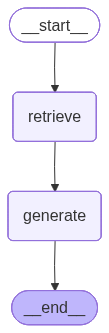

In [ ]:
from IPython.display import Image, display

display(Image(basic_graph.get_graph().draw_mermaid_png()))

In [ ]:
result = basic_graph.invoke({"question": "What are the hazardous decomposition products of BAYBLEND M750?"})

print("Question:", result["question"])
print("\nAnswer:", result["answer"])
print("\nContext length:", len(result["context"]), "chars")
print("\nContext preview:", result["context"][:200], "chars")

Question: What are the hazardous decomposition products of BAYBLEND M750?

Answer: I don't have enough information in the provided context to answer this question. The context only mentions that the product is not classified as hazardous according to OSHA's Hazard Communication Standard 2024 (29 CFR 1910.1200), but it does not provide information on the hazards identification, including decomposition products of BAYBLEND M750.

Context length: 451 chars

Context preview: 2. Hazards Identification  
 
This product is not classified as hazardous according to OSHA's Hazard Communication Standard 2024 (29 
CFR 1910.1200).

2. Hazards Identification  
 
This product is not chars


### Module checkpoint

Everything we built above is organized into reusable modules in the `rag/` directory:

| What we built | Module |
|--------------|--------|
| `load_page()`, `get_documents()` | `rag/data_loader.py` |
| `ChatOllama`, `OllamaEmbeddings` init | `rag/models.py` |
| Chunking + FAISS creation | `rag/vectorstore.py` |
| Basic LangGraph pipeline | `rag/pipeline.py` |